# Titanic Survival Analysis
Logan Schulthies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


train = pd.read_csv('train.csv')
train.rename(str.lower, axis='columns', inplace=True)
train.set_index('passengerid', inplace=True)

test = pd.read_csv('test.csv')
test.rename(str.lower, axis='columns', inplace=True)
test.set_index('passengerid', inplace=True)

combined = pd.concat([train, test])

combined.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration and Visualization
### Target: `survived`

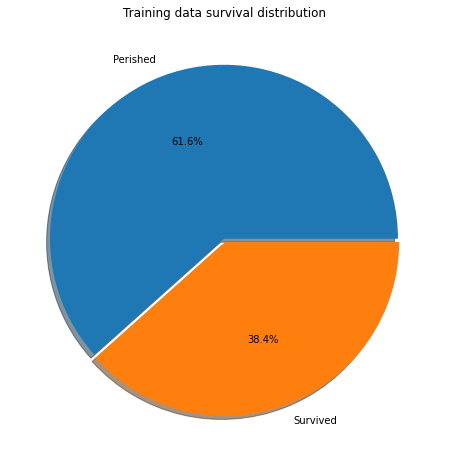

In [2]:
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(
    train.groupby('survived').survived.agg('count'),
    explode=[0.01, 0.01],
    labels=['Perished', 'Survived'],
    autopct='%1.1f%%',
    shadow=True
)
ax.set_title('Training data survival distribution')
plt.show()

We have an unbalanced sample---the majority of people died in the training set, nearly 62%.

### Continuous numeric variables: `age` and `fare`

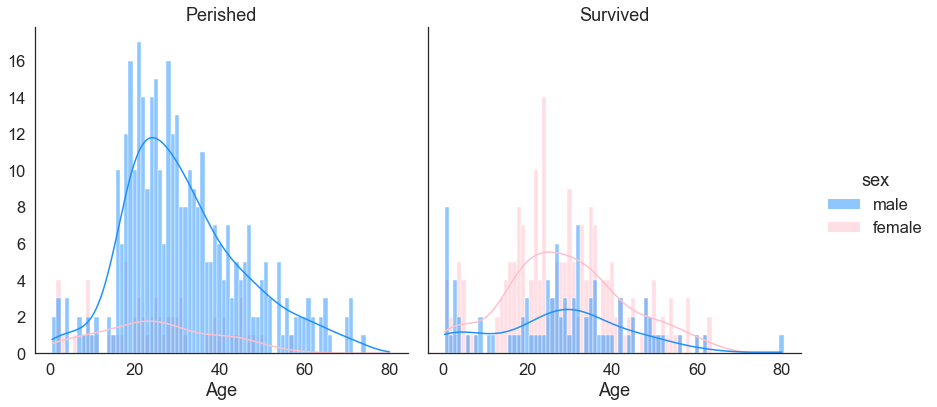

In [3]:
sns.set_theme(style='white', palette=['dodgerblue', 'pink'], font_scale=1.5)

p = sns.displot(data=train, x='age', hue='sex', col='survived', kde=True, binwidth=1, height=6)
p.set_titles(template="{col_var}")
p.set_xlabels('Age')
p.set_ylabels('')
p.axes_dict[0].set_title('Perished')
p.axes_dict[1].set_title('Survived')

plt.show()

Children are more likely to survive than adults. The mean survival age for women appears smaller than men. Men are much more likely to die than women.

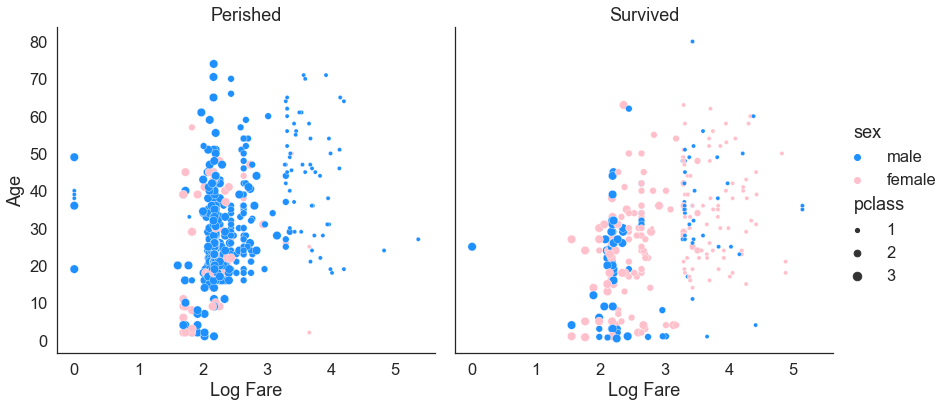

In [4]:
# Some tickets are for groups, we create a variable for avg fare over group
train['ticket_group'] = train.groupby('ticket').ticket.transform('count')
train['group_fare_avg'] = train.fare / train.ticket_group

p = sns.relplot(data=train, x=np.log(1+train.group_fare_avg), y='age', 
                col='survived', hue='sex', size='pclass', height=6)
p.axes_dict[0].set_title('Perished')
p.axes_dict[1].set_title('Survived')
p.set_ylabels('Age')
p.set_xlabels('Log Fare')
plt.show()

Of the females that die, they tend have a lower fare. Men also appear to have a better chance at survival with a higher fare.

### Discrete numeric variables: `sibsp`, and  `parch` 

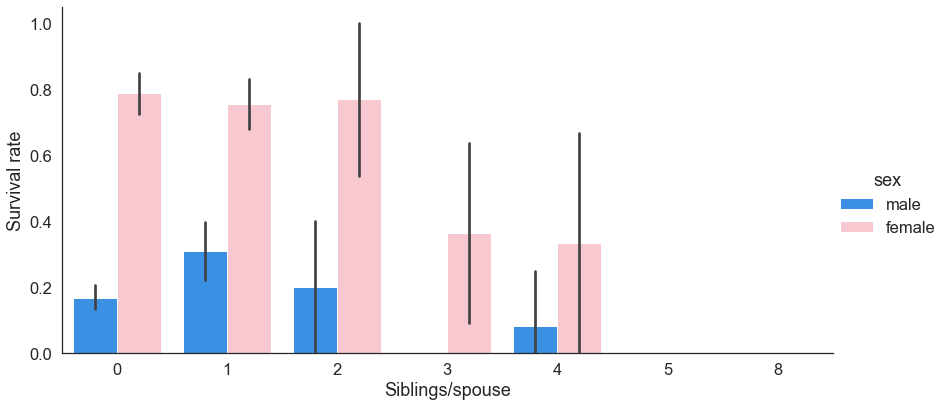

In [5]:
p=sns.catplot(data=train, x='sibsp',y='survived', hue='sex',
              kind='bar', height=6, aspect=2)
p.set_xlabels('Siblings/spouse')
p.set_ylabels('Survival rate')
plt.show()

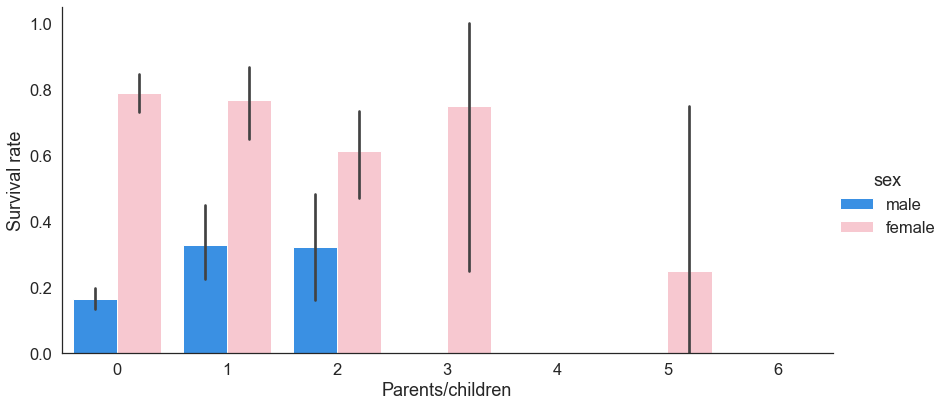

In [6]:
p=sns.catplot(data=train, x='parch',y='survived', hue='sex', 
              kind='bar', height=6, aspect=2)
p.set_xlabels('Parents/children')
p.set_ylabels('Survival rate')
plt.show()

Having children may possibly help men, it coulde be that `parch` and `sibsp` are correlated with age. It looks as though having a large family is detrimental to survival chances.

### Categorical and ordinal variables: `pclass`, `embarked`, `sex`

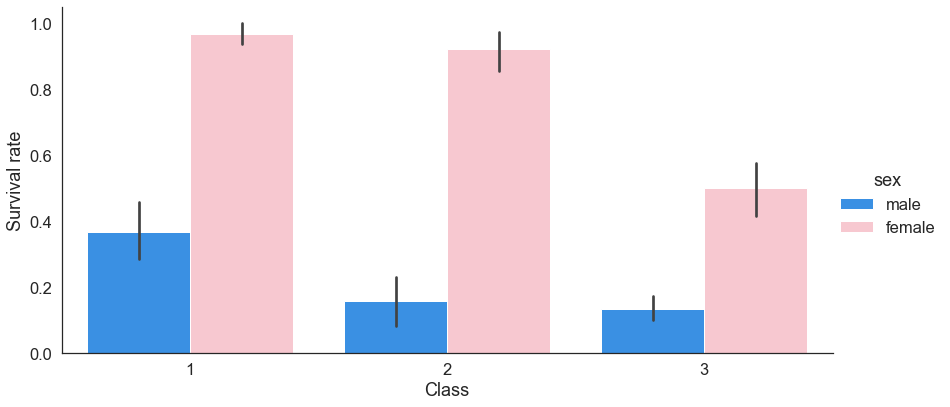

In [7]:
p = sns.catplot(data=train, x='pclass', y='survived', hue='sex', 
                kind='bar', height=6, aspect=2)
p.set_xlabels('Class')
p.set_ylabels('Survival rate')
plt.show()

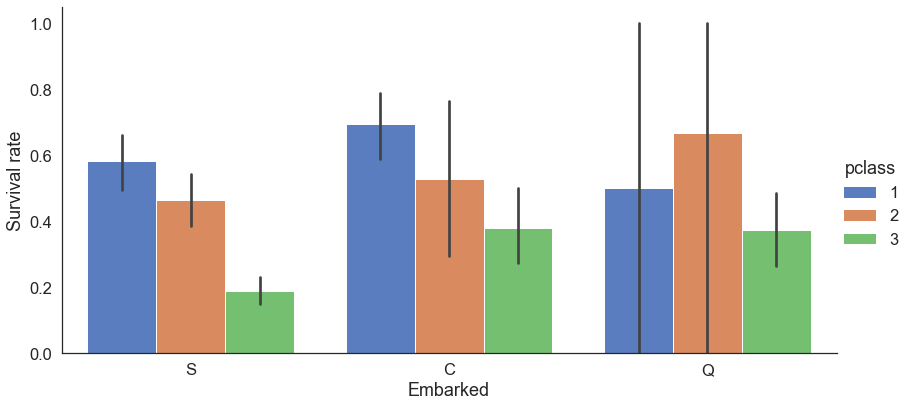

In [8]:
p = sns.catplot(data=train, x='embarked', y='survived', hue='pclass',
                kind='bar', height=6, aspect=2, palette='muted')
p.set_xlabels('Embarked')
p.set_ylabels('Survival rate')
plt.show()

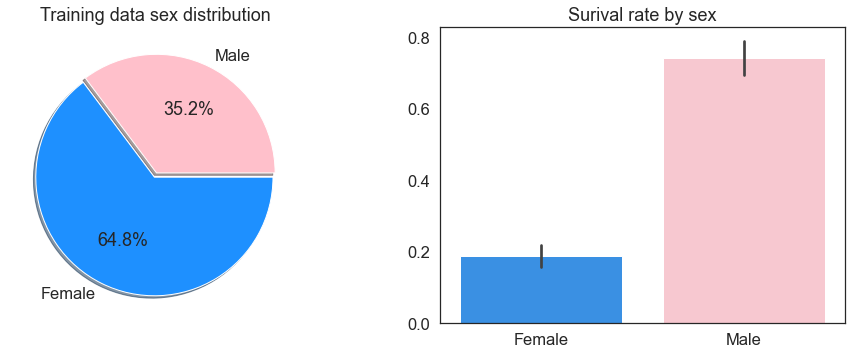

In [9]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax1.pie(
    train.groupby('sex').survived.agg('count'),
    explode=[0.02, 0.02],
    labels=['Male', 'Female'],
    colors=['pink', 'dodgerblue'],
    autopct='%1.1f%%',
    shadow=True
)
ax1.set_title('Training data sex distribution')

ax2 = fig.add_subplot(222)
sns.barplot(data=train, x='sex', y='survived')
ax2.set_title('Surival rate by sex')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=['Female', 'Male'])

plt.show()

## Feature Engineering

In [11]:
combined['family'] = combined.sibsp + combined.parch
combined['ticket_group'] = combined.groupby('ticket').ticket.transform('count')
combined.loc[combined.fare.isna(), 'fare'] = (
    np.mean(combined.query('pclass == 3 & ticket_group == 1').fare)
)
combined['group_fare_avg'] = combined.fare / combined.ticket_group

combined['surname'] = combined.name.str.split(',').str[0]
combined['title'] = (
    combined.name.str.split(',').str[1].str.split('.').str[0].str.strip()
)
combined.title = combined.title.replace(['Ms', 'Mlle'], 'Miss')
combined.title = combined.title.replace('Mme', 'Mrs')
combined.title = np.where(combined.title.isin(['Mr', 'Mrs', 'Miss', 'Master']), 
                          combined.title, 'Honorary')

combined['deck'] = combined.cabin.apply(lambda x: x[0] if pd.notna(x) else 'NA')

combined.deck = combined.deck.replace(['A', 'B', 'C'], 'ABC')
combined.deck = combined.deck.replace(['D', 'E'], 'DE')
combined.deck = combined.deck.replace(['F', 'G'], 'FG')

combined['child'] = combined.age < 13
combined['young'] = (combined.age > 12) & (combined.age < 31) 

combined['known_survivors_in_group'] = (
    combined.
    groupby('ticket').
    survived.
    transform(np.sum) 
    - combined.survived.fillna(0)
)
combined['group_mems_in_train'] = (
    combined.groupby('ticket').
    survived.transform(lambda x: x.notna().sum()) 
    - combined.survived.notna().astype(int)
)
combined['group_survival_rate'] = (
    combined.known_survivors_in_group / np.maximum(combined.group_mems_in_train, 1)
)
combined.group_survival_rate.fillna(np.mean(train.survived), inplace=True)
combined['group_survival_NA'] = ~combined.group_mems_in_train.astype('bool')
combined = combined.drop(['known_survivors_in_group', 'group_mems_in_train'], 1)

combined.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,...,family,ticket_group,group_fare_avg,surname,title,deck,child,young,group_survival_rate,group_survival_NA
passengerid,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,1,7.25000,Braund,Mr,NA,False,True,0.0,True
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,1,2,35.64165,Cumings,Mrs,ABC,False,False,0.0,True
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,1,7.92500,Heikkinen,Miss,NA,False,True,0.0,True
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,1,2,26.55000,Futrelle,Mrs,ABC,False,False,0.0,False
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,0,1,8.05000,Allen,Mr,NA,False,False,0.0,True


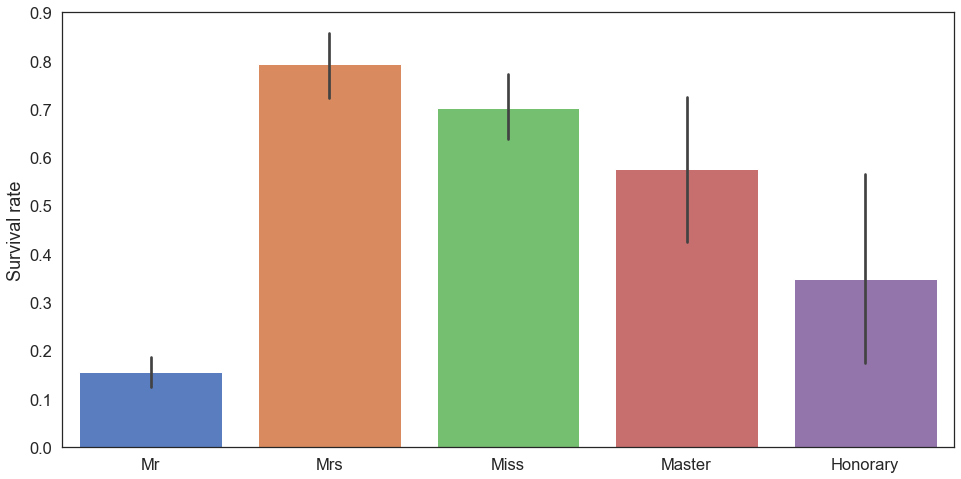

In [12]:
X = combined[:train.shape[0]]

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
sns.barplot(data=X, x='title', y='survived', palette='muted')
ax.set_ylabel('Survival rate')
ax.set_xlabel('')
plt.show()

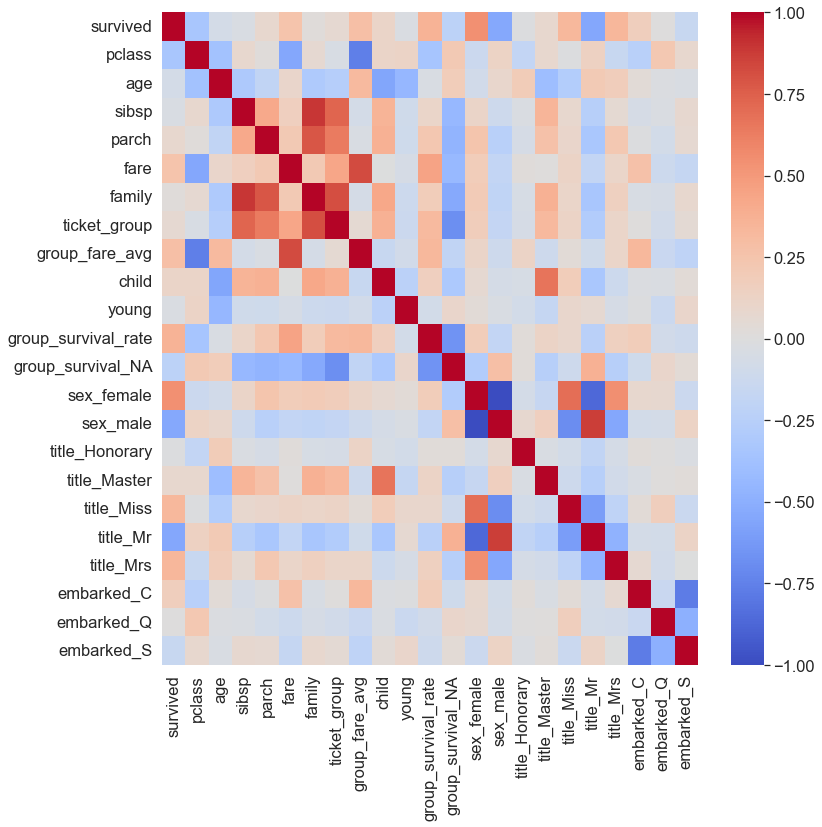

In [13]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(
    pd.get_dummies(X, columns=['sex', 'title', 'embarked']).corr(), 
    annot=False, cmap='coolwarm'
)
plt.show()

In [14]:
combined.age = np.where(combined.age.isna(), 
                        combined.groupby(['pclass', 'title']).age.transform(np.mean), 
                        combined.age)

# Fill in missing value for embarked
combined.loc[combined.embarked.isna(), 'embarked'] = 'S'

drop_cols = ['embarked', 'age',  'fare', 'survived', 'cabin', 
             'ticket', 'sibsp', 'parch', 'surname', 'name']
dummy_cols = ['sex','title', 'pclass', 'deck']

X = pd.get_dummies(
    combined[ :train.shape[0]].drop(drop_cols, 1), 
    columns=dummy_cols
)
X_submit = pd.get_dummies(
    combined[train.shape[0]: ].drop(drop_cols, 1), 
    columns=dummy_cols
)
y = combined[:train.shape[0]].survived

X.loc[X.deck_T == 1, 'deck_ABC']= 1 
X = X.drop(['deck_T'], 1)

X.head()

,family,ticket_group,group_fare_avg,child,young,group_survival_rate,group_survival_NA,sex_female,sex_male,title_Honorary,...,title_Miss,title_Mr,title_Mrs,pclass_1,pclass_2,pclass_3,deck_ABC,deck_DE,deck_FG,deck_NA
passengerid,,,,,,,,,,,,,,,,,,,,,
1,1,1,7.25000,False,True,0.0,True,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,1,2,35.64165,False,False,0.0,True,1,0,0,...,0,0,1,1,0,0,1,0,0,0
3,0,1,7.92500,False,True,0.0,True,1,0,0,...,1,0,0,0,0,1,0,0,0,1
4,1,2,26.55000,False,False,0.0,False,1,0,0,...,0,0,1,1,0,0,1,0,0,0
5,0,1,8.05000,False,False,0.0,True,0,1,0,...,0,1,0,0,0,1,0,0,0,1


## Modeling

### Random forest model

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X, y)
skf = StratifiedKFold(n_splits=5)

params = dict(n_estimators=np.arange(100,1001,100),
              min_samples_leaf=np.arange(2,7),
              max_depth=np.arange(2,6))

rfc = RandomForestClassifier(criterion='gini', oob_score=True)

cv = GridSearchCV(rfc, params, cv=skf, scoring='f1')
cv.fit(X.values, y)
cv.best_estimator_

RandomForestClassifier(max_depth=4, min_samples_leaf=4, oob_score=True)

## Prepare submission

This random forest gets ~80% accuracy on the submission. Without feature engineering or model tuning I get about 77%, which is about the same as using only gender to predict.

In [17]:
rfc = cv.best_estimator_
rfc.fit(X.values, y)
submit = pd.DataFrame({
    'PassengerId': X_submit.index,
    'Survived': rfc.predict(X_submit.values)
})
submit.Survived = submit.Survived.astype(int)
submit.to_csv('RF-model-predctions.csv', index=False)